In [1]:
import sys
[sys.path.append(i) for i in ['.', '..']]
import torch
from mirtorch.alg.cg import CG
from mirtorch.linear import NuSense, Diff3dgram, Gmri, GmriGram
import matplotlib.pyplot as plt
import h5py
import time
import os
from einops import rearrange

%load_ext autoreload
%autoreload 2

## Non-Cartesian, B0-informed reconstruction for 3D MRI
Here we tested a 3d non-Cartesian reconstruction task. Special thanks to Dinank Gupta from UofM for generously providing the data. 

### Load the data

In [2]:
# Download the files
if not os.path.exists('./3d.h5'):
    import wget
    url = "https://www.dropbox.com/s/o0l98u323zkgkpx/3d.h5?dl=1"
    wget.download(url, './3d.h5')
hf = h5py.File('./3d.h5', 'r')
nx = 128
ny = 128
nz = 15
device0 = torch.device('cuda:0')
# Load Non-cartesian k-space trajectory, [nbatch (1), ndimension, nshot, nreadout]
ktraj = torch.tensor(hf['ktraj'][()]).unsqueeze(0).to(device = device0, dtype = torch.float)
print('traj shape', ktraj.shape)
# Load k-space, [nbatch (1), ncoil, nshot, nreadout]
k = rearrange(torch.tensor(hf['k_r'][()] + 1j*hf['k_i'][()]), 'c s r -> 1 r c s').to(device = device0, dtype = torch.cfloat)
print('k shape', k.shape)
# Load sensetivity maps
smap = rearrange(torch.tensor(hf['s_r'][()] + 1j*hf['s_i'][()]), 'b c h w -> 1 b w h c').to(device = device0, dtype = torch.cfloat)
print('smap shape', smap.shape)
# Load fmaps
fmap = rearrange(torch.tensor(hf['b0'][()]), 'b c h -> 1 h c b').to(device = device0, dtype = torch.float)
# fmap = np.transpose(fmap, (0,2,1))
print('fmap shape', fmap.shape)

traj shape torch.Size([1, 3, 60, 4120])
k shape torch.Size([1, 8, 60, 4120])
smap shape torch.Size([1, 8, 128, 128, 15])
fmap shape torch.Size([1, 128, 128, 15])


In [3]:
# Define NuSENSE operator
# b0 = torch.tensor(fmap[iz,:,:]).to(device0).unsqueeze(0)
A = NuSense(smap, rearrange(ktraj, 'b c h w -> b c (h w)'))
Iadj = A.H*rearrange(k, 'b c h w -> b c (h w)')
T = Diff3dgram(A.size_in)
CG_NoB0 = CG(A.H*A+0.0001*T, max_iter = 20)
I_NoB0 = CG_NoB0.run(Iadj, Iadj)

In [4]:
# Define field-corrected Gmri operator
# b0 = torch.tensor(fmap[iz,:,:]).to(device0).unsqueeze(0)
Gop = Gmri(smaps=smap, zmap = -fmap, traj = ktraj, L = 10, nbins=40)
Ib0 = Gop.H*k
T = Diff3dgram(Gop.size_in)
start = time.time()
CG_FD_b0 = CG(Gop.H*Gop+0.0001*T, max_iter = 20)
I_FD_b0 = CG_FD_b0.run(Ib0, Ib0)
print('running time %f s'%(time.time()-start))

running time 217.963184 s


In [ ]:
# Define field-corrected Gmri operator, using the Toeplitz embedding approach.
# b0 = torch.tensor(fmap[iz,:,:]).to(device0).unsqueeze(0)
Gop = Gmri(smaps=smap, zmap=-fmap, traj=ktraj, L=10, nbins=30)
GtG = GmriGram(smaps=smap, zmap=-fmap, traj=ktraj, L=10, nbins=30)
Ib0 = Gop.H*k
T = Diff3dgram(Gop.size_in)
start = time.time()
CG_FD_b0 = CG(GtG+0.0001*T, max_iter = 20)
I_FD_b0 = CG_FD_b0.run(Ib0, Ib0)
print('running time %f s'%(time.time()-start))

In [13]:
plt.figure(figsize=(8,8))
plt.imshow(torch.abs(I_NoB0[0,0,:,:,10]).cpu().data.numpy(),cmap='gray')
# plt.colorbar()
plt.axis('off')
plt.title('CG-SENSE without B0)', size = 20)

running time 4.419846 s


Text(0.5, 1.0, 'CG-SENSE without B0)')

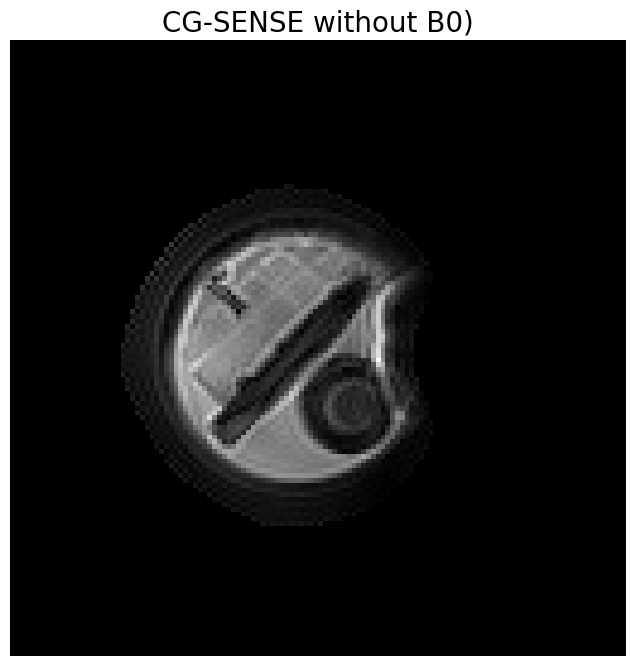

In [7]:
plt.figure(figsize=(8,8))
plt.imshow(torch.abs(I_NoB0[0,0,:,:,10]).cpu().data.numpy(),cmap='gray')
# plt.colorbar()
plt.axis('off')
plt.title('CG-SENSE without B0)', size = 20)

Text(0.5, 1.0, 'CG-SENSE with B0)')

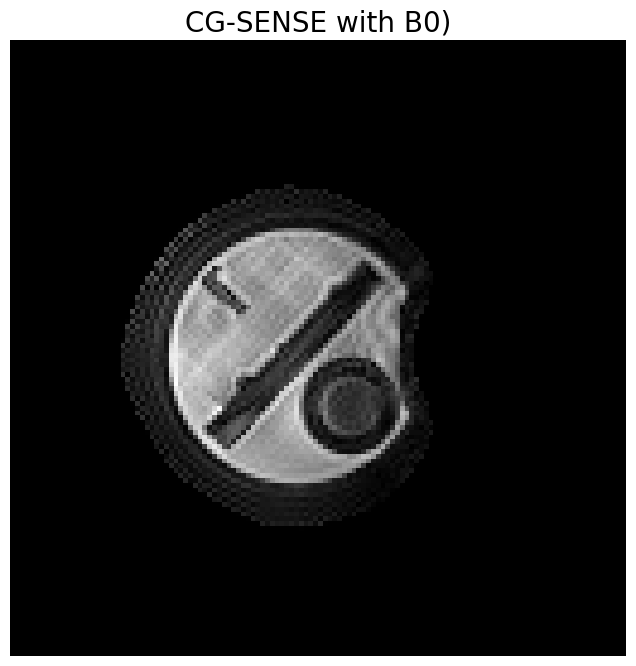

In [14]:
plt.figure(figsize=(8,8))
plt.imshow(torch.abs(I_FD_b0[0,0,:,:,10]).cpu().data.numpy(),cmap='gray')
# plt.colorbar()
plt.axis('off')
plt.title('CG-SENSE with B0)', size = 20)